# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## 1 Изучение данных из файла

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep= '\t')
print(data.head())
data.info()

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

На первый взгляд видно множество пропусков и других косяков. Надо исправлять!

## 2 Предобработка данных

Заполняем пропуски в данных где это нужно и меняем на подходящий тип данных

In [2]:
print(data['is_apartment'].unique())
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'] = data['is_apartment'].astype('bool')

[nan False True]


Будем считать, что Nan говорит о том, что это не апартамент (иначе это было бы указано в объявлении) и переведем весь столбец в bool

Пропуски присутствуют потому что не все те, кто размещал объявление посчитал важным указать пункт об апартаментах в объявлении

In [3]:
print(data['balcony'].isna().sum())
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

11519


Также будем считать отсутствие данных о количестве балконов за отсутствие балконов и заполним пропуски нулями.
Затем переведем столбец в int

In [4]:
print(data['floors_total'].isna().sum())
data = data.dropna(subset = ['floors_total'])
data['floors_total'] = data['floors_total'].astype('int')

print(data['kitchen_area'].isna().sum())
data = data.dropna(subset = ['kitchen_area'])

print(data['living_area'].isna().sum())
data = data.dropna(subset = ['living_area'])

86
2231
439


Удаляем строки с пропусками в столбцах 'living_area', 'kitchen_area' и 'floors_total'.

Также переводим 'floors_total' в int, но столбцы 'kitchen_area' и 'living_area' оставляем во float

In [5]:
print (data['first_day_exposition'].head())
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y.%m.%dT%H:%M:%S')
print (data['first_day_exposition'].head())

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
4    2018-06-19T00:00:00
5    2018-09-10T00:00:00
Name: first_day_exposition, dtype: object
0   2019-03-07
1   2018-12-04
2   2015-08-20
4   2018-06-19
5   2018-09-10
Name: first_day_exposition, dtype: datetime64[ns]


Переводим данные в столбце first_day_exposition в datetime для более удобного чтения информации о дате размещении объявления

In [6]:
data['last_price'] = data['last_price'].astype('int')
data['total_area'] = data['total_area'].astype('int')

Переводим значения в столбцах 'last_price' и 'total_area' из float в int 

In [7]:
print(data['locality_name'].isna().sum())
data = data.dropna(subset=['locality_name'])

print(data['locality_name'].nunique())
data['locality_name'] = data['locality_name'].str.lower()
print(data['locality_name'].nunique())

38
345
345


Сначала удаляем строки, в которых не указан населенный пункт.

Затем приводим столбец к нижнему регистру. И так как неявные дубликаты не обнаружены, значит дальнейшая обработка этого столбца не нужна 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20905 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20905 non-null  int64         
 1   last_price            20905 non-null  int64         
 2   total_area            20905 non-null  int64         
 3   first_day_exposition  20905 non-null  datetime64[ns]
 4   rooms                 20905 non-null  int64         
 5   ceiling_height        13318 non-null  float64       
 6   floors_total          20905 non-null  int64         
 7   living_area           20905 non-null  float64       
 8   floor                 20905 non-null  int64         
 9   is_apartment          20905 non-null  bool          
 10  studio                20905 non-null  bool          
 11  open_plan             20905 non-null  bool          
 12  kitchen_area          20905 non-null  float64       
 13  balcony         

**Вывод:**

Были удалены строки с пропусками в столбцах 'living_area', 'locality_name', 'kitchen_area' и 'floors_total'.

Также значения в некоторых столбцах были переведены в более подходящие типы данных.

Столбцы 'parks_around3000', 'ponds_around3000', 'airports_nearest', 'ponds_nearest', 'parks_nearest', 'cityCenters_nearest', 'ceiling_height' и 'days_exposition' не будем никак трогать, чтобы не портить данные, так как они нам ещё понадобятся при выявлении факторов, влияющих на стоимость квартиры

## 3 Расчёты и добавление результатов в таблицу

### 3.1 Цена квадратного метра

In [9]:
area_cost = []
area_cost = data['last_price']/data['total_area']
data.insert(3, 'area_cost', area_cost) 
data['area_cost'] = data['area_cost'].astype('int')

Добавляем в датафрейм столбец с ценой квадратного метра, который мы рассчитываем циклом, через деление цены на момент снятия с публикации на площадь квартиры в квадратных метрах ('last_price'/'total_area')

### 3.2 Этаж квартиры

In [10]:
data.insert(10,'floor_name', 'другой')
data.loc[(data['floor'] == 1), 'floor_name'] = 'первый'
data.loc[(data['floor'] == data['floors_total']) & (data['floor'] != 1), 'floor_name'] = 'последний'

Через цикл определяем этаж квартиры (первый, последний и другой) и добавляем в датафрейм в виде нового столбца

### 3.3 Соотношение жилой и общей площади и отношение площади кухни к общей

In [11]:
living_to_total = []
kitchen_to_total = []
living_to_total = round(data['living_area']/data['total_area'], 2)
kitchen_to_total = round(data['kitchen_area']/data['total_area'], 2)

data.insert(9, 'living_to_total', living_to_total)
data.insert(16, 'kitchen_to_total', kitchen_to_total)

Находим отношение жилой площади к общей и отношение площади кухни к общей и добавляем 2 столбца с полученными данными в датафрейм.

### 3.4 День недели, месяц и год публикации объявления

In [12]:
weekday = []
weekday = data['first_day_exposition'].dt.weekday
data.insert(5, 'weekday', weekday)

month = []
month = data['first_day_exposition'].dt.month
data.insert(6, 'month', month)

year = []
year = data['first_day_exposition'].dt.year
data.insert(7, 'year', year)

Вынимаем из столбца first_day_exposition данные о дне недели, месяце и годе публикации объявления и добавляем в датафрейм в виде новых столбцов

## 4 Исследовательский анализ данных

### 4.1 Гистограммы площади, цены, числа комнат, высоты потолков

187


<AxesSubplot:>

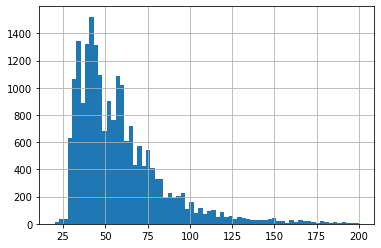

In [13]:
print(data[data['total_area'] > 200]['total_area'].count())
data['total_area'].hist(bins= 70, range = (20, 200))

<AxesSubplot:>

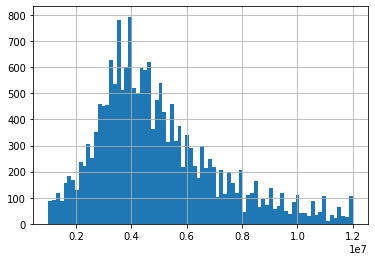

In [14]:
#print(data[data['last_price'] > 20000000]['last_price'].count())
data['last_price'].hist(bins = 80, range = (1000000, 12000000))

<AxesSubplot:>

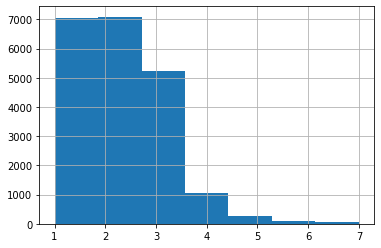

In [15]:
#print(data[data['rooms'] > 4]['rooms'].count())
data['rooms'].hist(bins = 7, range=(1,7))

<AxesSubplot:>

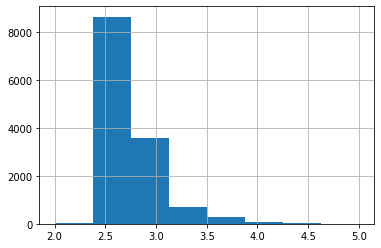

In [16]:
#print(data[data['ceiling_height'] > 5]['ceiling_height'].count())
data['ceiling_height'].hist(bins = 8, range=(2, 5))

### 4.2 Время продажи квартиры

1587


<AxesSubplot:>

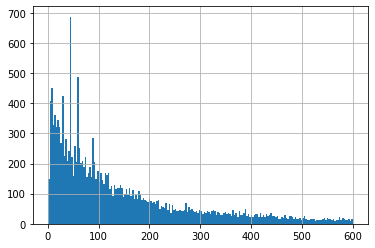

In [17]:
print(data[data['days_exposition'] > 500]['days_exposition'].count())
data['days_exposition'].hist(bins = 200, range=(1, 600))

In [18]:
print('Среднее значение:', int(data['days_exposition'].mean()))
print('Медианное значение', int(data['days_exposition'].median()))

Среднее значение: 185
Медианное значение 102


Обычно продажа квартиры занимает примерно от 30 до 200 дней

Необычайно быстрая продажа - до 2 недель, а необычайно долгая - это больше 1.5 лет.

### 4.3 Отброс странных данных

In [19]:
#print(data[data['days_exposition'] == 60]['days_exposition'].count())
#print(data[data['days_exposition'] == 45]['days_exposition'].count())
#print(data[data['days_exposition'] > 500]['last_price'].count())
data = data.loc[data['days_exposition'] < 500]
#print(data[data['rooms'] > 6]['last_price'].count())
data = data.loc[data['rooms'] < 7]
#print(data[data['total_area'] > 300]['total_area'].count())
data = data.loc[data['total_area'] < 300]

Отбрасываем объявления с квартирами, в которых конат больше 6 и общая площадь превышает 300 метров кв. 
Такие предложения крайне редки и только собьют при дальнейшем анализе данных.

Также отбрасываем сделки, которые завершались дольше 500 дней.

Странные аномальные значения в 45 и 60 дни. Уж больно многовато закрытых сделок конкретно в эти 2 дня.

### 4.4 Какие факторы больше всего влияют на стоимость квартиры?

Изучим, зависит ли цена от площади, числа комнат и удалённости от центра

47
0.37430273891105886


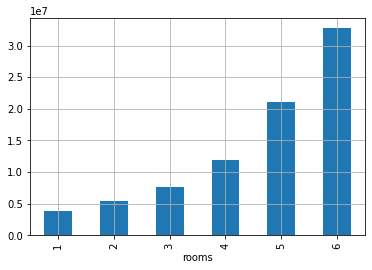

In [20]:
print(data[data['rooms'] == 6]['last_price'].count())
data.groupby('rooms')['last_price'].agg('mean').plot(kind = 'bar', grid = True)
print(data['rooms'].corr(data['last_price']))

0.6561923169522417


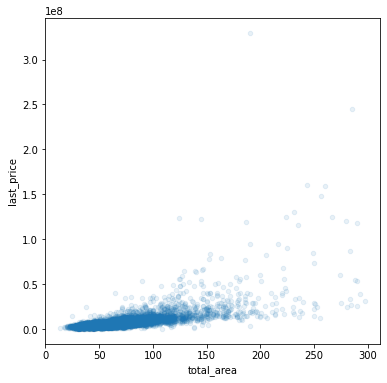

In [21]:
data.plot(x='total_area', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))
print(data['total_area'].corr(data['last_price']))

-0.24318440689281023


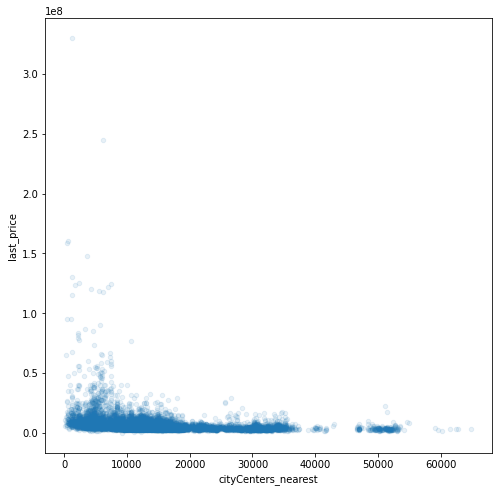

In [22]:
data.plot(x='cityCenters_nearest', y='last_price', kind = 'scatter', alpha=0.1, figsize=(8, 8))
print(data['cityCenters_nearest'].corr(data['last_price']))

Да. Стоимость квартиры зависит от всех 3 факторов: площади, числа комнат и удалённости от центра. Это также подтверждается и результатами подсчета корреляции

Изучим зависимость цены от того, на каком этаже расположена квартира (первом, последнем или другом)

<AxesSubplot:xlabel='floor_name'>

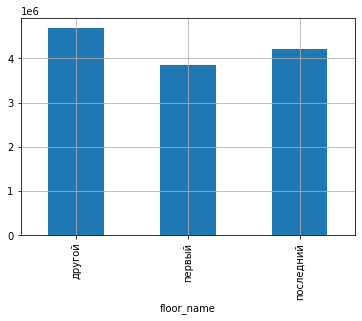

In [23]:
data.groupby('floor_name')['last_price'].agg('median').plot(kind = 'bar', grid = True)

Ярко выраженной зависимости между стоимостью квартиры и этажом, на котором она находится нет, однако можно заметить, что квартиры, находящиеся на первых этажах явно проседают в стоимости по сравнению со всеми другими.

И наконец изучим зависимость от даты размещения: дня недели, месяца и года.

<AxesSubplot:xlabel='weekday'>

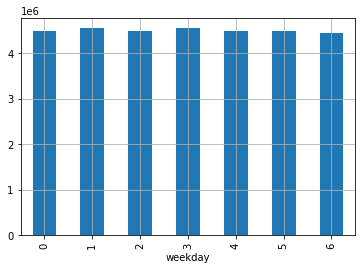

In [24]:
data.groupby('weekday')['last_price'].agg('median').plot(kind = 'bar', grid = True)

<AxesSubplot:xlabel='month'>

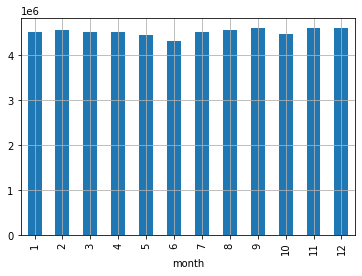

In [25]:
data.groupby('month')['last_price'].agg('median').plot(kind = 'bar', grid = True)

<AxesSubplot:xlabel='year'>

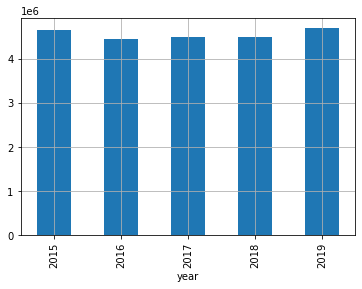

In [26]:
data.groupby('year')['last_price'].agg('median').plot(kind = 'bar', grid = True)

Из факторов день недели, месяц и год размещения публикации реальное влияние на стоимость квартиры не оказывает ни один из факторов 

##### Вывод: 
На стоимость квартиры действительно существенно влияют 3 фактора: площадь, число комнат и удалённость от центра.

Ярко выраженной зависимости между стоимостью квартиры и этажом, на котором она находится нет, однако можно заметить, 
что квартиры, находящиеся на первых этажах явно проседают в стоимости по сравнению со всеми другими.

День недели, месяц и год размещения объявления никак не влияют на стоимость квартиры. 

### 4.5 10 населённых пунктов с наибольшим числом объявлений

In [27]:
top_ten = data.groupby(by='locality_name').agg({'locality_name':'count', 'area_cost':'sum'}).rename(columns={'locality_name':'amount'}).sort_values(by='amount', ascending = False).reset_index().head(10)
top_ten['mean_cost'] = (top_ten['area_cost']/top_ten['amount']).astype('int')
top_ten = top_ten.drop('area_cost', axis = 1)

In [28]:
display(top_ten.sort_values(by='mean_cost', ascending=False))

,locality_name,amount,mean_cost
0,санкт-петербург,10989,110983
6,пушкин,248,102658
8,деревня кудрово,198,92933
5,посёлок парголово,249,90297
1,посёлок мурино,372,86295
9,петергоф,150,83166
2,посёлок шушары,344,78079
3,колпино,276,74707
4,всеволожск,272,69293
7,гатчина,228,68073


Самая высокая стоимость жилья в Санкт-петербурге. Самая низкая - в Гатчине

### 4.6 Расстояние до центра в Санкт-Петербурге

In [29]:
piter = data[data['locality_name'] == 'санкт-петербург']
piter = piter.dropna(subset = ['cityCenters_nearest'])
center_nearest = (piter['cityCenters_nearest']/1000).astype('int')
piter.insert(24, 'center_nearest', center_nearest)

In [30]:
center_distance = piter.groupby(by='center_nearest').agg({'center_nearest':'count', 'area_cost':'sum'}).rename(columns={'center_nearest':'amount'}).reset_index()
center_distance['center_distance_mean'] = (center_distance['area_cost']/center_distance['amount']).astype('int')
center_distance = center_distance.drop('area_cost', axis = 1)

display(center_distance.sort_values(by='center_distance_mean', ascending=False))

,center_nearest,amount,center_distance_mean
0,0,53,170414
1,1,131,162812
2,2,195,141432
7,7,288,140168
5,5,457,139681
6,6,290,137868
4,4,545,133399
27,27,2,132115
3,3,314,119489
8,8,439,118170


<AxesSubplot:xlabel='center_nearest', ylabel='center_distance_mean'>

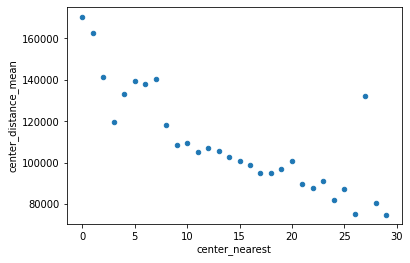

In [31]:
center_distance.plot(x='center_nearest', y='center_distance_mean', kind = 'scatter')

Судя по графику, можно считать 0-8км центром, а 9км и далее уже остальным городом. 

### 4.7 Какие факторы влияют на стоимость квартиры в центре?

In [32]:
center = piter.loc[piter['center_nearest'] < 9]
center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 4 to 23690
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          2712 non-null   int64         
 1   last_price            2712 non-null   int64         
 2   total_area            2712 non-null   int64         
 3   area_cost             2712 non-null   int64         
 4   first_day_exposition  2712 non-null   datetime64[ns]
 5   weekday               2712 non-null   int64         
 6   month                 2712 non-null   int64         
 7   year                  2712 non-null   int64         
 8   rooms                 2712 non-null   int64         
 9   ceiling_height        1720 non-null   float64       
 10  floors_total          2712 non-null   int64         
 11  living_area           2712 non-null   float64       
 12  living_to_total       2712 non-null   float64       
 13  floor            

0.6561923169522417


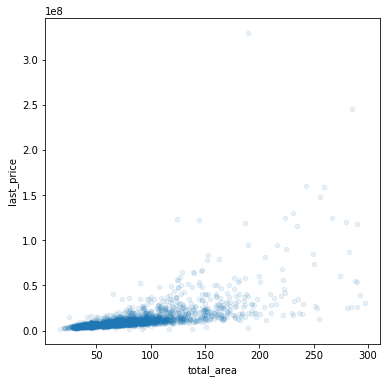

In [33]:
center.plot(x='total_area', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))
print(data['total_area'].corr(data['last_price']))

0.37430273891105886


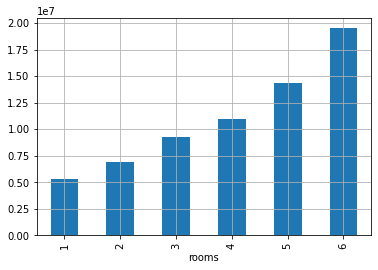

In [34]:
center.groupby('rooms')['last_price'].agg('median').plot(kind = 'bar', grid = True)
print(data['rooms'].corr(data['last_price']))

0.08469819042817406


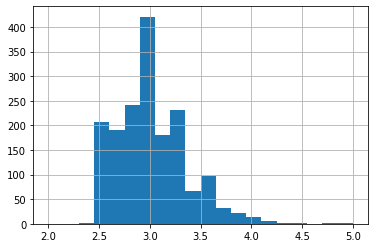

In [35]:
#print(data.groupby('ceiling_height')['last_price'].median())
center['ceiling_height'].hist(bins = 20, range = (2, 5))
print(data['ceiling_height'].corr(data['last_price']))

0.037462709563723294


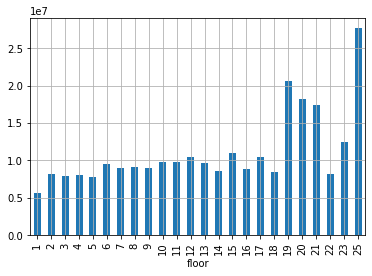

In [36]:
center.groupby('floor')['last_price'].agg('median').plot(kind = 'bar', grid = True)
#print(center['floor'].value_counts())
print(data['floor'].corr(data['last_price']))

<AxesSubplot:xlabel='floor_name'>

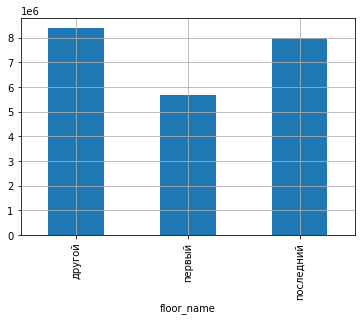

In [37]:
center.groupby('floor_name')['last_price'].agg('median').plot(kind = 'bar', grid = True)

<AxesSubplot:xlabel='center_nearest'>

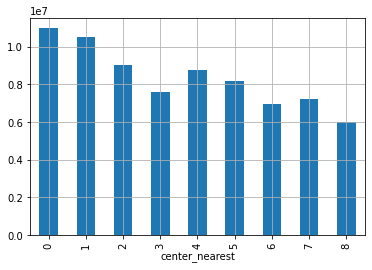

In [38]:
center.groupby('center_nearest')['last_price'].agg('median').plot(kind = 'bar', grid = True)

<AxesSubplot:xlabel='first_day_exposition', ylabel='last_price'>

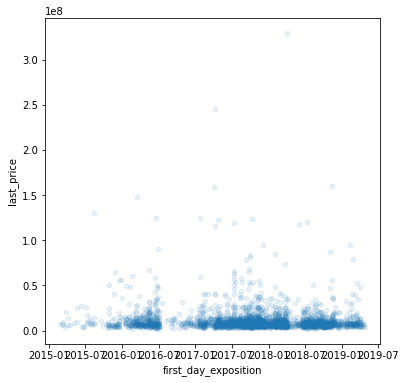

In [39]:
center.plot(x='first_day_exposition', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))

-0.029065002259805562
0.003593987224965091
-0.09690089187513613


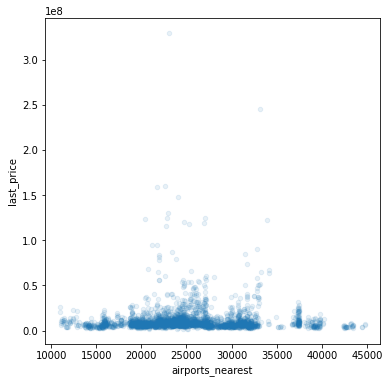

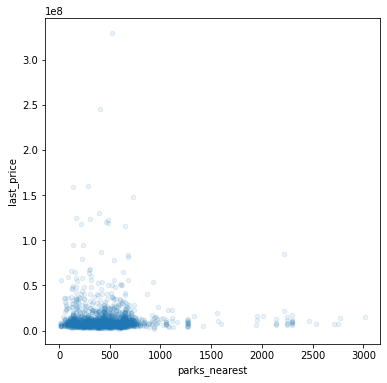

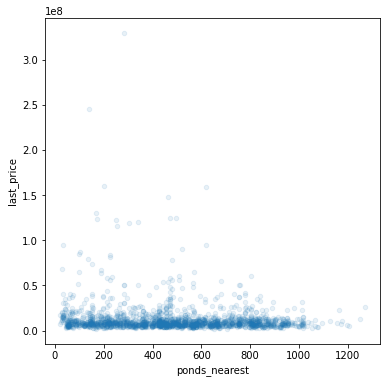

In [40]:
center.plot(x='airports_nearest', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))
print(data['airports_nearest'].corr(data['last_price']))
center.plot(x='parks_nearest', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))
print(data['parks_nearest'].corr(data['last_price']))
center.plot(x='ponds_nearest', y='last_price', kind = 'scatter', alpha=0.1, figsize=(6, 6))
print(data['ponds_nearest'].corr(data['last_price']))

0.18093974189901443


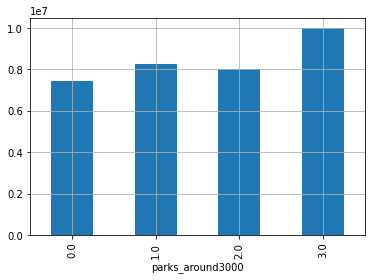

In [41]:
center.groupby('parks_around3000')['last_price'].agg('median').plot(kind = 'bar', grid = True)
print(data['parks_around3000'].corr(data['last_price']))

0.17910842486142717


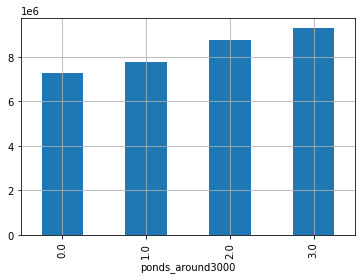

In [42]:
center.groupby('ponds_around3000')['last_price'].agg('median').plot(kind = 'bar', grid = True)
print(data['ponds_around3000'].corr(data['last_price']))

0.021466722443598072


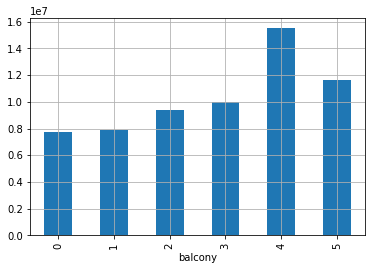

In [43]:
center.groupby('balcony')['last_price'].agg('median').plot(kind = 'bar', grid = True)
print(data['balcony'].corr(data['last_price']))

0.12355875581730687


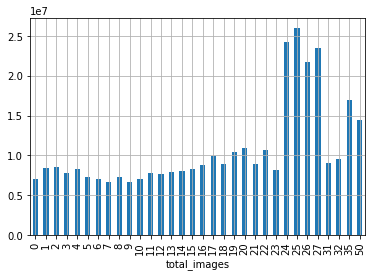

In [44]:
center.groupby('total_images')['last_price'].agg('median').plot(kind = 'bar', grid = True)
#print(center['total_images'].value_counts())
print(data['total_images'].corr(data['last_price']))

##### Вывод: 
На стоимость квартиры существенно влияют такие факторы как площадь, число комнат и удалённость от центра (даже внутри самого центра).

Ярко выраженной зависимости между стоимостью квартиры и этажом, на котором она находится нет, однако можно заметить, 
что квартиры, находящиеся на первых этажах явно проседают в стоимости по сравнению со всеми другими.

Имеются и другие факторы, имеющие какое-никакое влияние на стоимость квартиры. Количество балконов, хотя скорее это можно списать на площадь квартиры и количество комнат, т.к. количество балконов напрямую зависит от этих факторов. Наличие парков и водоёмов в шаговой доступности также благоприятно влияют на цену квартир. Наличие аэропорта в относительной близости (20-30км).

Факторы, не влияющие на стоимость квартир или влияющих слишком незначительно: высота потолков, день недели, месяц и год размещения объявления, количество фотографий в объявлении.

Сравнивая с выводом по общей базе замечаем, что площадь, количество комнат и удаленность от центра всё так же явно влияют на стоимость квартир.

И по сути сильных различий между центром и всей базой не заметно

## Общий вывод

Был проведен обширный анализ различных данных и проверены различные гипотезы о том, какие факторы влияют на стоимость квартир, а какие нет.

Самыми явными и важными факторами, напрямую влияющими на стоимость квартиры являются площадь, число комнат и удалённость от центра. 

Менее значительными, но всё же имеющими влияние на цену квартиры являются наличие парков и водоёмов в шаговой доступности, наличие аэропорта в относительной близости, а также этаж квартиры (1 этаж ощутимо бьет по цене квартиры).

Так же стоит упомянуть о том, что на цены квартир в центре и на цены квартир по всей базе влияют одни и те же факторы с минимальными отклонениями. 